In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, utils

In [18]:
SIZE = 32

def add_ResidualLayer(inputs):
    x = layers.Conv2D(
        SIZE,
        kernel_size=(3, 3),
        padding='same',
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

#     x = layers.Conv2D(
#         SIZE,
#         kernel_size=(3, 3),
#         padding='same',
#         use_bias=False
#     )(x)
#     x = layers.BatchNormalization()(x)

    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    
    return x


def add_ValueHead(model):
    model = layers.Conv2D(
        1,
        kernel_size=(1, 1),
        padding='same',
        use_bias=False
    )(model)
    model = layers.BatchNormalization()(model)
    model = layers.Activation('relu')(model)
    model = layers.Flatten()(model)
#     model = layers.Dense(SIZE, activation='relu')(model)
    model = layers.Dense(1)(model)
    model = layers.Activation('tanh', name='value_out')(model)
    
    return model


def add_PolicyHead(model):
    model = layers.Conv2D(
        2,
        kernel_size=(1, 1),
        padding='same',
        use_bias=False
    )(model)
    model = layers.BatchNormalization()(model)
    model = layers.Activation('relu')(model)
    model = layers.Flatten()(model)
    model = layers.Dense(8 * 8 + 1, name='policy_out')(model)
    
    return model


def get_model():
    inputs = layers.Input(shape=(8, 8, 2))
    model = layers.Conv2D(
        SIZE,
        kernel_size=(3, 3),
        padding='same',
        use_bias=False
    )(inputs)
    model = layers.BatchNormalization()(model)
    model = layers.Activation('relu')(model)
    
    for _ in range(10):
        model = add_ResidualLayer(model)
    
    value_out = add_ValueHead(model)
    policy_out = add_PolicyHead(model)
    
    ret = models.Model(
        inputs=inputs,
        outputs=[value_out, policy_out],
        name='kiwi-zero'
    )
    
    return ret


def plot_model(model=None):
    if model == None:
        model = get_model()
    
    utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
# FILE_NAME = '../2019-09-15 232553.txt'
FILE_NAME = '../2019-09-17 232747.txt'
X, y_values, y_policy = [], [], []

def encode_field(field):
    if field == 0:
        return [0, 0]
    elif field == -1:
        return [1, 0]
    else:
        return [0, 1]

with open(FILE_NAME) as file:
    for line in file:
        line = line.strip()
        line_split = line.split(' ')
        
        turn = int(line_split[-2])
        board = [encode_field(int(field) * turn) for field in line_split[:64]]
        policy = [float(prob) for prob in line_split[64:128 + 1]]
        value = float(line_split[-1]) * turn
        
        X.append(board)
        y_values.append(value)
        y_policy.append(policy)
        
X = np.array(X)
y_values = np.array(y_values)
y_policy = np.array(y_policy)

X = X.reshape(-1, 8, 8, 2)
print(X.shape)
print(y_values.shape)
print(y_policy.shape)

(7132, 8, 8, 2)
(7132,)
(7132, 65)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_values_train, y_values_test, y_policy_train, y_policy_test = train_test_split(X, y_values, y_policy, test_size=0.2)

In [25]:
losses = {
    "value_out": "mse",
    "policy_out": "mse",
}

model = get_model()
model.compile(
    optimizer=tf.train.AdamOptimizer(0.0003),
    loss=losses,
    metrics=['mae']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor='val_loss'
    )
]

history = model.fit(
    X_train,
    { 'value_out': y_values_train, 'policy_out': y_policy_train },
    epochs=1000,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

Train on 4564 samples, validate on 1141 samples
Epoch 1/1000
4564/4564 [==============================] - 64s 14ms/sample - loss: 1.1455 - value_out_loss: 1.0308 - policy_out_loss: 0.1127 - value_out_mean_absolute_error: 0.9834 - policy_out_mean_absolute_error: 0.2267 - val_loss: 1.0146 - val_value_out_loss: 0.9934 - val_policy_out_loss: 0.0213 - val_value_out_mean_absolute_error: 0.9926 - val_policy_out_mean_absolute_error: 0.1182
Epoch 2/1000
4564/4564 [==============================] - 62s 14ms/sample - loss: 0.9389 - value_out_loss: 0.9275 - policy_out_loss: 0.0113 - value_out_mean_absolute_error: 0.9374 - policy_out_mean_absolute_error: 0.0820 - val_loss: 1.0153 - val_value_out_loss: 0.9920 - val_policy_out_loss: 0.0232 - val_value_out_mean_absolute_error: 0.9921 - val_policy_out_mean_absolute_error: 0.1229
Epoch 3/1000
4564/4564 [==============================] - 62s 14ms/sample - loss: 0.8564 - value_out_loss: 0.8475 - policy_out_loss: 0.0085 - value_out_mean_absolute_error: 0.8

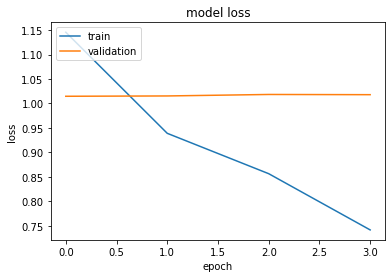

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['policy_out_loss'])
# plt.plot(history.history['value_out_loss'])
# plt.plot(history.history['val_policy_out_loss'])
# plt.plot(history.history['val_value_out_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
plot_model(model)